In [1]:
import sys
sys.path.append("../script/")

from sklearn.metrics import classification_report,accuracy_score
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import importlib
from time import time
import Functions
from matplotlib import pyplot as plt


In [2]:
# ref from 2segp github
# Classification dataset names - choose from following datasets 

CLASS_DATASET_NAMES = ['bcw','heart','iono','parks','sonar']
dataset_name = CLASS_DATASET_NAMES[0]

# Load the dataset
Xy = np.genfromtxt('test_data/'+dataset_name+'.csv', delimiter=',')
X = Xy[:, :-1]
y = Xy[:, -1]   # last column is the label

# simple operators
boost_num = 1000

seed = np.random.randint(9999999)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed)

# Data

In [1353]:
df = pd.read_csv('test_data/simple_line.csv')
df['z'] = df['z'].replace('a',0)
df['z'] = df['z'].replace('b',1)

data = df.to_numpy()
X = data[:,:-1]
x = data[:,0]
y = data[:,1]

label = data[:,-1]

# X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3)

i = label == 0

ax = data[i][:,0]
ay = data[i][:,1]

i = label == 1
bx = data[i][:,0]
by = data[i][:,1]

In [31]:
n = 10000

i = 5
j = 2

x = np.random.random(n)
y = np.random.random(n)

X = np.array([x,y]).T
label = y < i*x**j

index = y > (i*x**j + 0.1)
ax = x[index]
ay = y[index]

index = y < (i*x**j - 0.1)
bx = x[index]
by = y[index]


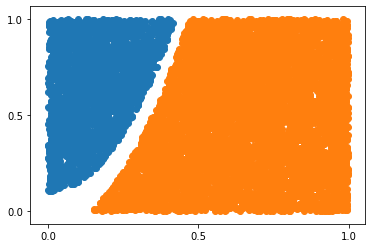

In [32]:
plt.scatter(ax,ay)
plt.scatter(bx,by)
plt.xticks([0,0.5,1])
plt.yticks([0,0.5,1])
plt.show()

In [40]:
bins

array([[-0.99299466,  0.        ,  1.        ],
       [-0.99286207,  1.        ,  1.        ],
       [-0.98959522,  0.        ,  1.        ],
       ...,
       [-0.00225385,  1.        ,  1.        ],
       [-0.00217299,  0.        ,  1.        ],
       [        inf,  1.        ,  1.        ]])

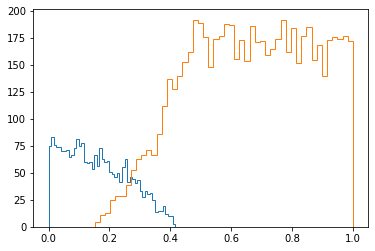

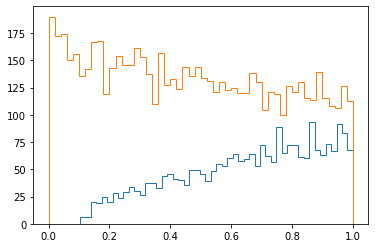

In [42]:
plt.hist(ax,bins=50,histtype='step')
plt.hist(bx,bins=50,histtype='step')
plt.show()

plt.hist(ay,bins=50,histtype='step')
plt.hist(by,bins=50,histtype='step')
plt.show()

# Test

In [34]:
def calculate_fitness(val,label):
    df = pd.DataFrame(val,columns=['value'])
    df['label'] = label

    items = df.value_counts(sort=False).iteritems()
    (pv,pl),pc = next(items)

    columns = []

    col = [pv,pl,0,[0,0,0]]
    col[3][pl] = pc
    col[-2] += 1
    swtich = 0


    for (v,l),c in items:
        if v != pv:
            columns.append(col)        
            col = [v,-1,0,[0,0,0]]
        col[3][l] = c
        if max(col[3]) == c:
            col[1] = l
        col[-2] += 1
        pv = v

    columns.append(col)

    bins = []
    bin = columns[0][:3]
    counts = []
    count = columns[0][3]

    for i in range(1,len(columns)):
        col = columns[i]
        
        if (col[1] != bin[1]) or ((bin[2] == 1) != (col[2] == 1)):
            bin[0] = (bin[0]+col[0])/2
            bins.append(bin)
            counts.append(count)
            
            bin = col[:3]
            count = col[3]
        else:
            for i in range(3):
                count[i] += col[3][i]
                bin[0] = col[0]
    bin[0] = np.inf
    bins.append(bin)
    counts.append(count)

    bins = np.array(bins)
    counts = np.array(counts)
    
    return bins,counts

5 : 3911 10000.0 2.5568908207619536 1.0


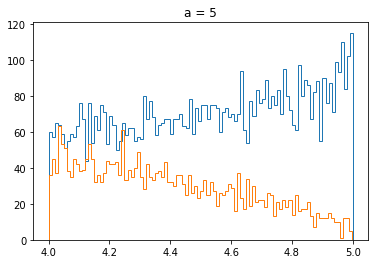

5 : 512 10000.0 19.53125 1.0


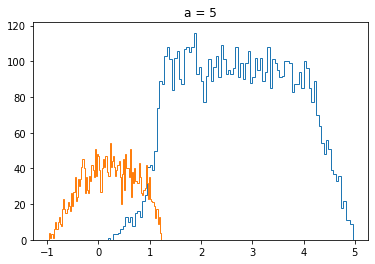

5 : 2 10000.0 5000.0 1.0


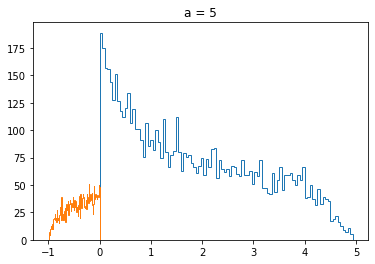

5 : 1090 10000.0 9.174311926605505 1.0


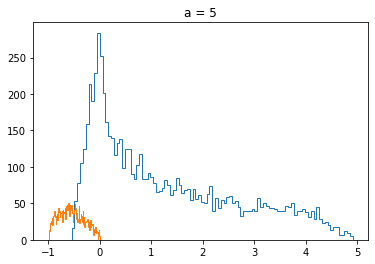

5 : 1758 10000.0 5.688282138794084 1.0


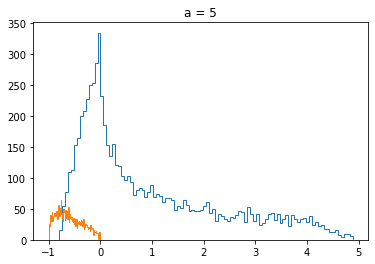

5 : 2334 10000.0 4.284490145672665 1.0


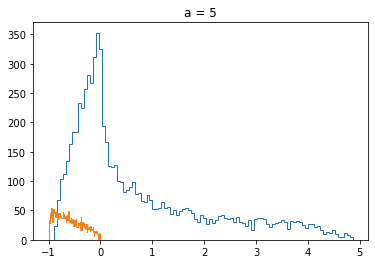

5 : 2594 10000.0 3.8550501156515034 1.0


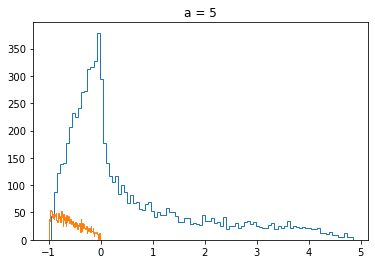

5 : 2824 10000.0 3.5410764872521248 1.0


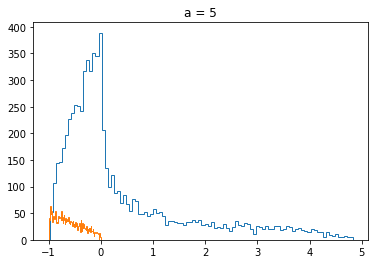

5 : 2968 10000.0 3.3692722371967654 1.0


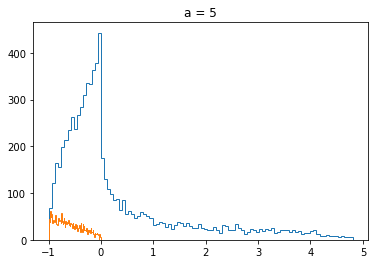

5 : 3090 10000.0 3.236245954692557 1.0


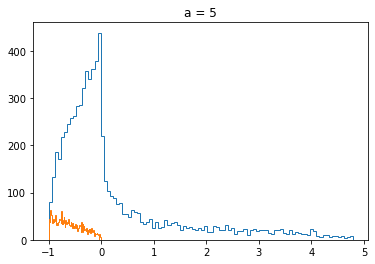

In [39]:
a = i
b = j

for b in range(10):
    # val = i*x**j +x - y
    val = a*x**b - y
    av = val[label==True]
    bv = val[label==False]
    
    bins,counts = calculate_fitness(val,label)

    total = counts.sum(axis=1)
    gini = np.sum((counts.T/total)**2,axis=0)
    fitness = np.sum(gini * total)
    print(a,":",len(bins),fitness,fitness/len(bins),fitness/sum(total))
    
    plt.hist(av,bins=100,histtype='step')
    plt.hist(bv,bins=100,histtype='step')
    plt.title("a = "+str(a))
    plt.show()

In [145]:
pd.value_counts(X_train[0])

107    1
352    1
dtype: int64

# Engine

In [1335]:
import numpy as np
import pandas as pd
from time import time
from Node import Node

In [1532]:
class Engine:
    def __init__(self,opset,X,Y,log_odds,p,learning_rate):
        self.generation = 0
#         self.X_train,self.X_valid,self.y_train,self.y_valid = train_test_split(X,Y,train_size=0.9)
        X = X.astype('float64')
        Y = Y.astype('int')
        self.opset = opset
        
        self.num_class = len(pd.unique(Y))
        self.feature_space = X.shape[1]
        
        self.vals = X.T
        self.X = X
        self.Y = Y

        self.log_odds = log_odds
        self.p = p
        self.residual = self.Y - p
        self.learning_rate = learning_rate

        self.count_label = pd.value_counts(Y).reset_index().values
        
        self.best = (np.inf,None)
        self.nodes = [Node(True,index=i) for i in range(self.feature_space)]
    def count_bins(self,val):
        df = pd.DataFrame(val,columns=['value'])
        df['label'] = self.Y

        items = df.value_counts(sort=False).iteritems()
        (pv,pl),pc = next(items)

        columns = []

        col = [pv,pl,0,[0,0,0]]
        col[3][pl] = pc
        col[-2] += 1
        swtich = 0


        for (v,l),c in items:
            if v != pv:
                columns.append(col)        
                col = [v,-1,0,[0,0,0]]
            col[3][l] = c
            if max(col[3]) == c:
                col[1] = l
            col[-2] += 1
            pv = v

        columns.append(col)

        bins = []
        bin = columns[0][:3]
        counts = []
        count = columns[0][3]

        for i in range(1,len(columns)):
            col = columns[i]
            
            if (col[1] != bin[1]) or ((bin[2] == 1) != (col[2] == 1)):
                bin[0] = (bin[0]+col[0])/2
                bins.append(bin)
                counts.append(count)
                
                bin = col[:3]
                count = col[3]
            else:
                for i in range(3):
                    count[i] += col[3][i]
                    bin[0] = col[0]
        bin[0] = np.inf
        bins.append(bin)
        counts.append(count)

        bins = np.array(bins)
        counts = np.array(counts)
        
        return bins,counts
    
    def loss(self,vals,numbins,beta):
        fitness = []
        
        for val in vals:
            
            bins,counts = self.count_bins(val)
            total = counts.sum(axis=1)
            gini = np.sum((counts.T/total)**2,axis=0)
            
            fitness.append(beta[0]*-np.sum(gini * total)/sum(total) + beta[1] * len(bins)/10000)
            
        return fitness
    
    def evolve(self,total_size,batch_size,elite_size,bins,beta,verbose):
        self.generation += 1
        
        if verbose:
            print("\tgeneration:",self.generation)
            t = time()
        
        num_batches = total_size//batch_size
        pool = self.nodes

        elites_funcs = []
        elite_sons = []
        elite_vals = []

        elites_fitness = []
        for j in range(num_batches):

            funcs = np.random.choice(list(self.opset.keys()),size=batch_size)
            arg_count = [self.opset[func] for func in funcs]
            sons = np.random.choice(pool,size = sum(arg_count))
            it = iter(sons)
            sons = [[next(it) for _ in range(arg_count[i])] for i in range(batch_size)]
            vals = [funcs[i]([self.vals[s.index] for s in sons[i]]) for i in range(batch_size)]

            vals = np.stack(vals)
            fitness = self.loss(vals,bins,beta)
            
            elites_funcs.extend(funcs)
            elite_sons.extend(sons)
            elite_vals.extend(vals)
            elites_fitness.extend(fitness)

            rank = np.argsort(elites_fitness)

            elites_funcs = [elites_funcs[index] for index in rank[:elite_size]]
            elite_sons = [elite_sons[index] for index in rank[:elite_size]]
            elite_vals = [elite_vals[index] for index in rank[:elite_size]]
            elites_fitness = [elites_fitness[index] for index in rank[:elite_size]]

        for index in range(elite_size):
            node = Node(False,
                func=elites_funcs[index],
                sons=elite_sons[index],
                index=len(self.nodes),
                fit=elites_fitness[index] 
            )
            
            self.nodes.append(node)
            self.vals = np.append(self.vals,[elite_vals[index]],axis=0)
            
            if index == 0:
                if self.best[0] > node.fitness:
                    val = elite_vals[index]
                    b,counts = self.count_bins(val)
                    
                    self.best = (node.fitness,node,b)
            # self.test_param_same(node)
      

        if verbose:
            print("\t",np.min(elites_fitness))
            print("\ttime",time()-t)
        return None

    def test_param_same(self,node):
        v1 = node.predict(self.X)
        v2 = self.vals[node.index]
        if np.any(v1!=v2):
            print(node.index,v1==v2)

In [1546]:
eg = Engine(Functions.simple_opset,X,label,init_log_odds,init_p,0)
for i in range(10):
    eg.evolve(30,30,10,2,[1,5,0],1)

	generation: 1
	 -0.62792312
	time 1.2439846992492676
	generation: 2
	 -0.9235
	time 1.3201911449432373
	generation: 3
	 -0.8205
	time 0.6948196887969971
	generation: 4
	 -0.9235
	time 0.8775687217712402
	generation: 5
	 -0.8365
	time 0.8775420188903809
	generation: 6
	 -0.9235
	time 1.0533287525177002
	generation: 7
	 -0.9255
	time 1.255786418914795
	generation: 8
	 -0.8985
	time 0.9738717079162598
	generation: 9
	 -0.924
	time 1.1249384880065918
	generation: 10
	 -0.921
	time 1.1185195446014404


In [1547]:
eg.best[:2],len(eg.best[2])

((-0.9255,
  ( _minus -> ( _minus -> ( _divide -> ( _minus -> |0| |1| ) ( _minus -> |0| |0| ) ) ( _minus -> ( _divide -> ( _minus -> |0| |1| ) ( _multiply -> |0| |0| ) ) ( _add -> ( _divide -> ( _divide -> |0| |0| ) ( _minus -> |0| |0| ) ) ( _divide -> ( _minus -> |0| |0| ) ( _divide -> |0| |0| ) ) ) ) ) ( _divide -> ( _multiply -> |0| |0| ) ( _minus -> ( _add -> ( _add -> |0| |0| ) ( _divide -> ( _add -> |0| |0| ) ( _add -> |0| ( _minus -> |0| |1| ) ) ) ) ( _divide -> ( _divide -> |0| |0| ) ( _minus -> |0| |0| ) ) ) ) )),
 149)

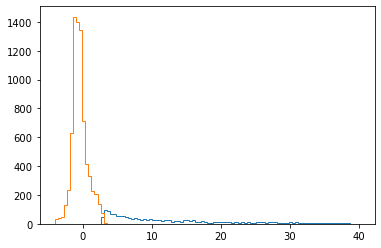

In [1548]:
val = eg.vals[eg.best[1].index]
av = val[label==True]
bv = val[label==False]

# plt.hist(av,bins=100,histtype='step')
# plt.show()
# plt.hist(bv,bins=100,histtype='step')
plt.hist(av,bins=100,histtype='step',range=(-4,40))
plt.hist(bv,bins=100,histtype='step',range=(-4,40))
plt.show()